## Governing Equations for Knickpoint Retreat
Bressan et al. (2014) start from the Exner equation for bed elevation $z(x,t)$:

$$
\frac{\partial z}{\partial t} \;+\; \frac{1}{1-\lambda_s}\frac{\partial q_s}{\partial x} \;=\; 0
$$

where

* $z$ = bed elevation \[m]
* $t$ = time \[s]
* $x$ = streamwise coordinate \[m]
* $\lambda_s$ = soil porosity \[–]
* $q_s$ = volumetric sediment flux per unit width \[m$^2$/s]

The sediment flux is linked to the knickpoint face height $h$ and the migration rate $\tfrac{dx}{dt}$ (erosion velocity). After substituting a shear–stress-based erosion law and simplifying, the governing PDE reduces to a **generalized Burgers’ equation**:

$$
\frac{\partial z}{\partial t} \;-\; C \,\frac{\partial z}{\partial x} \;-\; D \,\frac{\partial^2 z}{\partial x^2} \;=\; 0
$$

## Advection and Diffusion Coefficients

The coefficients are physically based and given by:

$$
C = \frac{h \, k_d \, \gamma}{1-\lambda_s}\; S_0 \, M \, A
$$

$$
D = \frac{h \, k_d \, \gamma}{1-\lambda_s}\; S_0 \, H_0 \, M \, B
$$

where

* $h$ = knickpoint face height \[m]
* $k_d$ = soil erodibility \[m$^2$ s / kg]
* $\gamma$ = water specific weight \[N/m$^3$]
* $S_0$ = upstream bed slope \[–]
* $H_0$ = upstream flow depth \[m]
* $M, A, B$ = dimensionless parameters from hydraulic effects (M2 curve, expansion, slope dependence)

## Modified Peclet Number

The **modified Peclet number** expresses the ratio of advection to diffusion in the retreat process:

$$
Pe \;=\; \frac{C \, h}{D} \;=\; \frac{A h}{B H_0}
$$

Interpretation:

* $Pe \gg 1$: advection-dominated retreat (face migrates upstream sharply)
* $Pe \ll 1$: diffusion-dominated retreat (slope relaxes gradually)
* $Pe \sim 1$: mixed advective–diffusive behavior

In the Python implementation:

* `C` and `D` are defined using the above formulas (or equivalently by prescribing $Pe$ and one coefficient).
* If you set `Pe` manually, then `D` is computed as:

$$
D = \frac{|C|\, h}{Pe}
$$

## Step Initial Condition: IMEX Knickpoint Retreat (Upstream Migration)

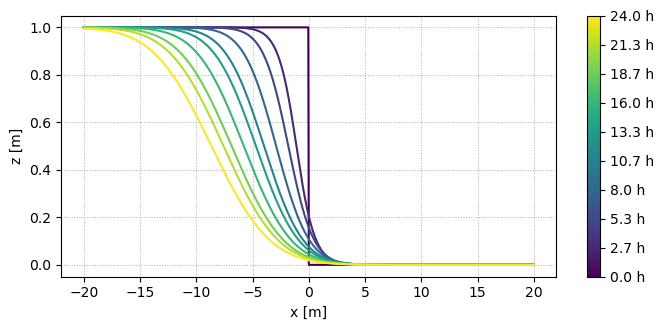

Pe=1, C=-1.000e-04 m/s, D=1.000e-04 m^2/s, dt=3600 s, Nt=24, Courant=7.20, IC=step, kappa=0.3


In [38]:
import numpy as np
import scipy.sparse as sp, scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm

# ------- domain -------
Lx, Nx = 40.0, 801
x = np.linspace(-Lx/2, Lx/2, Nx); dx = x[1]-x[0]

# ------- physics (Pe-controlled) -------
h   = 1.0
Pe  = 1.0                 # larger => more advective
C   = -1.0e-4              # NEGATIVE => upstream (leftward) retreat
D   = abs(C)*h/Pe          # keep D > 0 regardless of C sign

# ------- time (manual) -------
dt    = 60.0*60.0          # s
t_end = 24.0*3600.0        # s
save_at = np.linspace(0.0, t_end, 10)  # EXACTLY 10 times for colorbar

# ------- initial condition -------
IC_type = "step"           # "step" or "arctan"
kappa   = 0.3              # arctan steepness if IC_type == "arctan"
if IC_type == "step":
    z = np.where(x < 0.0, 1.0, 0.0).astype(float)
else:
    z = -np.arctan(kappa * x).astype(float)

# ------- helpers -------
def advect_semi_lagrangian(z, C, dt, x):
    x_d = np.clip(x - C*dt, x[0], x[-1])  # clamp => Neumann-like
    return np.interp(x_d, x, z)

def build_diff_solver(Nx, dx, D, dt):
    if D == 0.0:
        return lambda zin: zin
    lower2 = np.ones(Nx-1)/dx**2
    main2  = -2.0*np.ones(Nx)/dx**2
    upper2 = np.ones(Nx-1)/dx**2
    main2[0]   = -2.0/dx**2; upper2[0]  =  2.0/dx**2   # Neumann
    main2[-1]  = -2.0/dx**2; lower2[-1] =  2.0/dx**2
    D2 = sp.diags([lower2, main2, upper2], [-1,0,1], shape=(Nx,Nx), format='csc')
    A  = sp.identity(Nx, format='csc') - dt*(D*D2)
    return spla.factorized(A)

solve_diff = build_diff_solver(Nx, dx, D, dt)

# ------- integrate (IMEX: advect -> diffuse) -------
Nt = int(np.ceil(t_end/dt)); t_end = Nt*dt
shots = {0.0: z.copy()} if 0.0 in save_at else {}
t = 0.0
for _ in range(Nt):
    z_star = advect_semi_lagrangian(z, C, dt, x)
    z      = solve_diff(z_star)
    t += dt
    for ts in save_at:
        if ts not in shots and abs(t - ts) <= 0.5*dt:
            shots[ts] = z.copy()
for ts in save_at:
    if ts not in shots:
        shots[ts] = z.copy() if abs(t_end - ts) < 1e-12 else shots.get(0.0, z.copy())

# ------- plot (viridis colorbar, 10 ticks) -------
fig, ax = plt.subplots(figsize=(7,3.4))
cmap = cm.viridis
norm = plt.Normalize(vmin=0.0, vmax=t_end)
for ts in save_at:
    ax.plot(x, shots[ts], color=cmap(norm(ts)))
sm = ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, ax=ax, ticks=save_at)
cbar.ax.set_yticklabels([f"{val/3600:.1f} h" for val in save_at])
ax.set_xlabel("x [m]"); ax.set_ylabel("z [m]")
ax.grid(True, ls=":", lw=0.7)
plt.tight_layout(); plt.show()

nu = abs(C)*dt/dx
print(f"Pe={Pe:.3g}, C={C:.3e} m/s, D={D:.3e} m^2/s, dt={dt:.0f} s, Nt={Nt}, Courant={nu:.2f}, IC={IC_type}, kappa={kappa}")

## Arctan Initial Condition: IMEX Knickpoint Retreat (Upstream Migration)

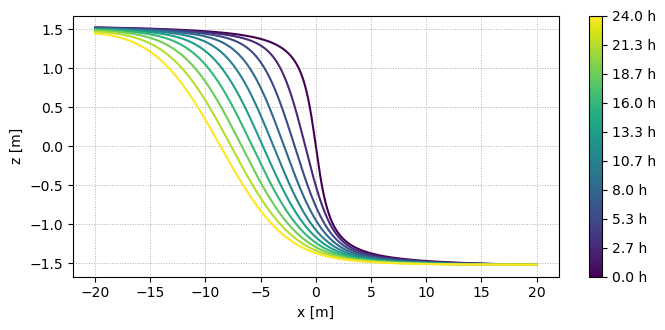

Pe=1, C=-1.000e-04 m/s, D=1.000e-04 m^2/s, kappa=1, dt=600.0 s, Nt=144, Courant=1.20


In [39]:
import numpy as np
import scipy.sparse as sp, scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm

# ---------- domain ----------
Lx, Nx = 40.0, 801
x = np.linspace(-Lx/2, Lx/2, Nx); dx = x[1]-x[0]

# ---------- physics via Pe (set ONE of C or D) ----------
h  = 1.0
Pe = 1.0
C  = -abs(1.0e-4)        # NEGATIVE => upstream (leftward)
D  = abs(C)*h/Pe         # keep D positive

# ---------- time ----------
dt    = 600.0
t_end = 24.0*3600.0
save_at = np.linspace(0.0, t_end, 10)

# ---------- initial condition: z(x,0) = -arctan(kappa * x) ----------
kappa = 1
z = -np.arctan(kappa * x).astype(float)

# ---------- helpers ----------
def advect_semi_lagrangian(z, C, dt, x):
    x_d = np.clip(x - C*dt, x[0], x[-1])  # C<0 shifts left (upstream)
    return np.interp(x_d, x, z)

def diffusion_solver(Nx, dx, D, dt):
    if D == 0.0: return lambda zin: zin
    lower2 = np.ones(Nx-1)/dx**2
    main2  = -2.0*np.ones(Nx)/dx**2
    upper2 = np.ones(Nx-1)/dx**2
    main2[0]   = -2.0/dx**2; upper2[0]  =  2.0/dx**2
    main2[-1]  = -2.0/dx**2; lower2[-1] =  2.0/dx**2
    D2 = sp.diags([lower2, main2, upper2], [-1,0,1], shape=(Nx,Nx), format='csc')
    A  = sp.identity(Nx, format='csc') - dt*(D*D2)
    return spla.factorized(A)

solve_diff = diffusion_solver(Nx, dx, D, dt)

# ---------- integrate (IMEX: advect -> diffuse) ----------
Nt = int(np.ceil(t_end/dt)); t_end = Nt*dt
shots = {0.0: z.copy()}
t = 0.0
for _ in range(Nt):
    z_star = advect_semi_lagrangian(z, C, dt, x)
    z = solve_diff(z_star)
    t += dt
    for ts in save_at:
        if ts not in shots and abs(t - ts) <= 0.5*dt:
            shots[ts] = z.copy()
times_to_plot = [ts for ts in save_at if ts in shots]

# ---------- plot with viridis colorbar (10 ticks) ----------
fig, ax = plt.subplots(figsize=(7, 3.4))
cmap = cm.viridis
norm = plt.Normalize(vmin=0.0, vmax=t_end)
for ts in times_to_plot:
    ax.plot(x, shots[ts], color=cmap(norm(ts)))

sm = ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, ax=ax, ticks=save_at)
cbar.ax.set_yticklabels([f"{val/3600:.1f} h" for val in save_at])

ax.set_xlabel("x [m]"); ax.set_ylabel("z [m]")
ax.grid(True, ls=":", lw=0.7)
plt.tight_layout(); plt.show()

nu = abs(C)*dt/dx
print(f"Pe={Pe:.3g}, C={C:.3e} m/s, D={D:.3e} m^2/s, kappa={kappa:.3g}, dt={dt:.1f} s, Nt={Nt}, Courant={nu:.2f}")